Rows: 15906
Countries: 264
Years: 1963 to 2023
  Country Name  Year  Production
0  Afghanistan  1963       300.0
1  Afghanistan  1964       300.0
2  Afghanistan  1965       300.0
3  Afghanistan  1966       300.0
4  Afghanistan  1967       400.0


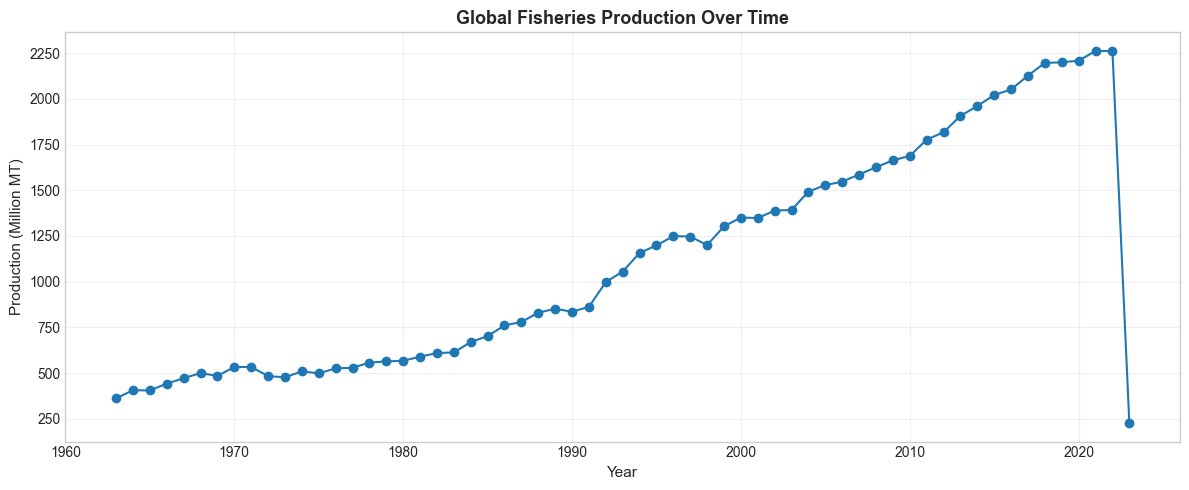

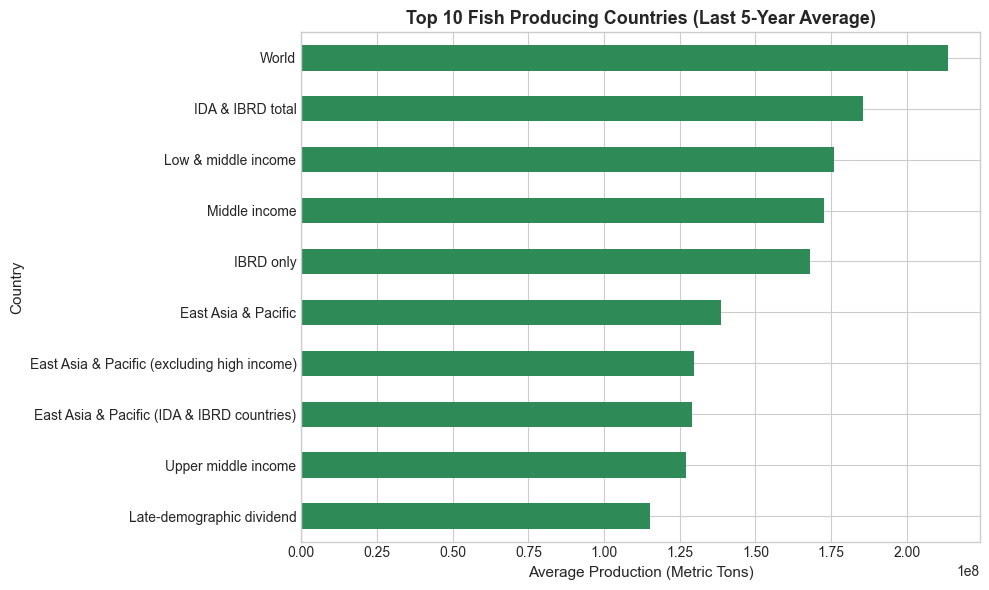


Top 10 Producers:
1. World: 213,474,586 MT
2. IDA & IBRD total: 185,634,273 MT
3. Low & middle income: 175,845,861 MT
4. Middle income: 172,573,547 MT
5. IBRD only: 168,154,771 MT
6. East Asia & Pacific: 138,584,810 MT
7. East Asia & Pacific (excluding high income): 129,670,229 MT
8. East Asia & Pacific (IDA & IBRD countries): 129,096,175 MT
9. Upper middle income: 127,070,978 MT
10. Late-demographic dividend: 115,031,674 MT


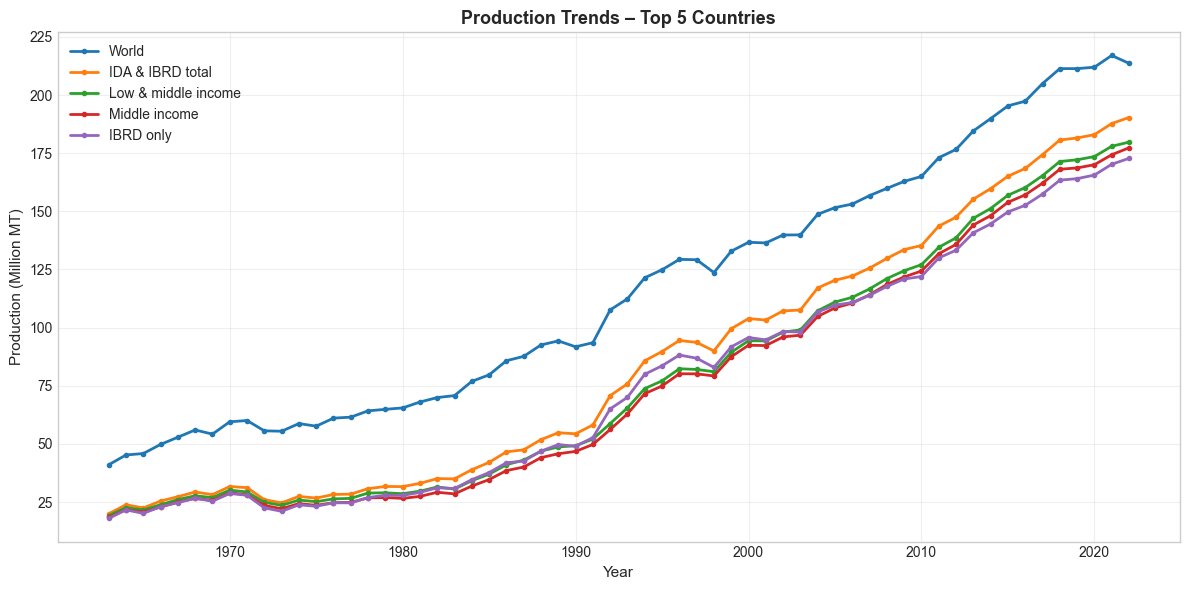


After feature engineering:
Rows: 15114
  Country Name  Year  Production  Production_Lag1  Production_Lag2  \
3  Afghanistan  1966       300.0            300.0            300.0   
4  Afghanistan  1967       400.0            300.0            300.0   
5  Afghanistan  1968       400.0            400.0            300.0   
6  Afghanistan  1969       460.0            400.0            400.0   
7  Afghanistan  1970       460.0            460.0            400.0   

   Production_Lag3  Rolling_Mean_3Y  
3            300.0       300.000000  
4            300.0       333.333333  
5            300.0       366.666667  
6            300.0       420.000000  
7            400.0       440.000000  

Training samples: 12,091
Testing samples:  3,023
Random Forest model trained successfully!

Test RMSE: 493,868 MT
Test R²:  0.999


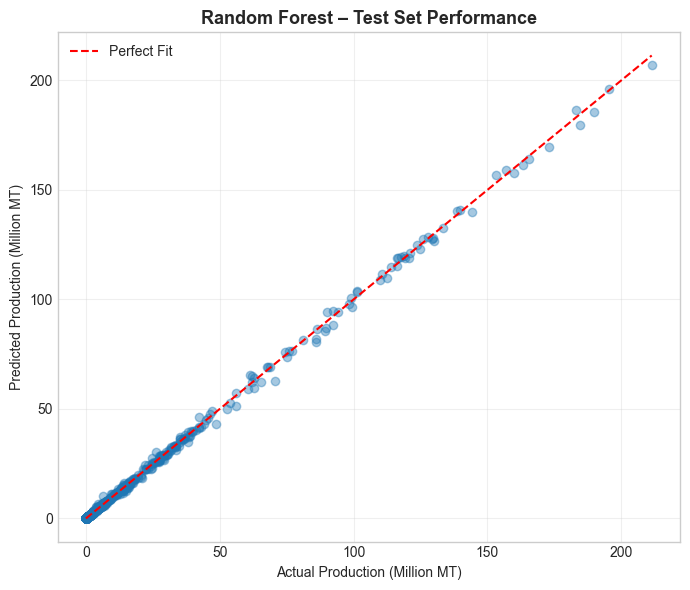

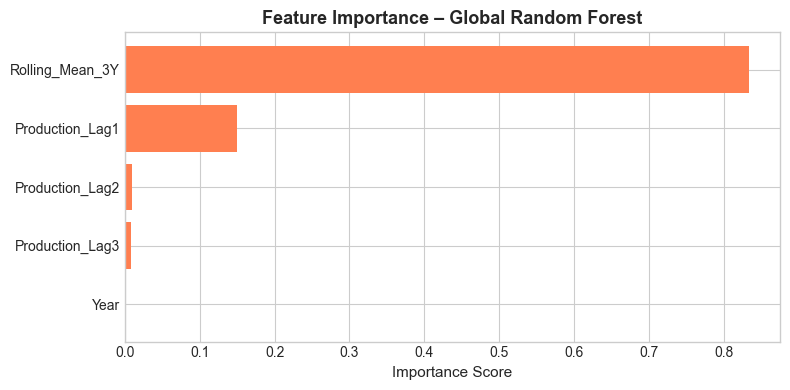


Feature Importance Ranking:
Rolling_Mean_3Y: 0.8333
Production_Lag1: 0.1496
Production_Lag2: 0.0091
Production_Lag3: 0.0079
Year: 0.0001

Forecasting for country: World
Years available: 1963 to 2022

Trend model fitted for World
Slope (change per year): 3,095,702 MT/year


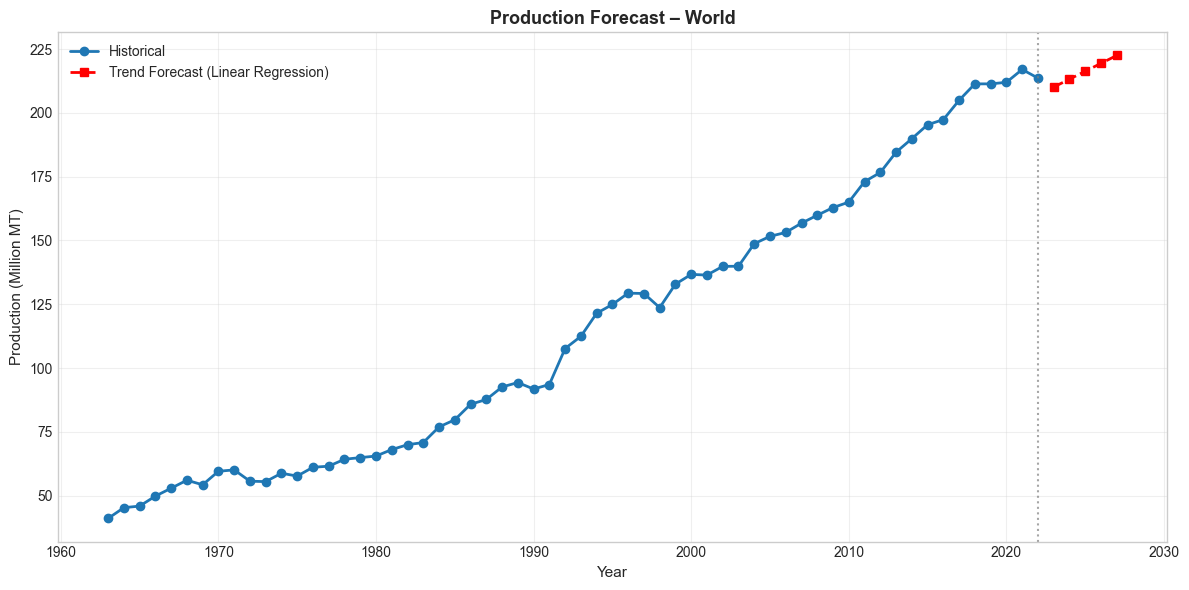


Trend-based predictions for World:
Year 2023: 210,082,024 MT
Year 2024: 213,177,726 MT
Year 2025: 216,273,428 MT
Year 2026: 219,369,129 MT
Year 2027: 222,464,831 MT

Summary:
- Analyzed long-term fisheries production data by country.
- Identified recent top producers and visualized their trends.
- Trained a global Random Forest on lag features for overall accuracy.
- Fitted a simple linear trend model per country for realistic future forecasts.


In [1]:
# ============================================
# Fisheries Production Analysis & Forecasting
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

# -----------------------------
# Step 1: Load and prepare data
# -----------------------------

# Adjust this path if needed
data_path = "fisheries_data_ml_ready.csv"

df = pd.read_csv(data_path)

# Standardize column names
df.columns = [c.strip() for c in df.columns]

# Try to normalize to expected column names
df = df.rename(columns={
    "Country": "Country Name",
    "Value": "Production"
})

# Keep only needed columns
required_cols = ["Country Name", "Year", "Production"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Current columns: {df.columns.tolist()}")

df = df[required_cols].copy()

# Basic cleaning
df = df.dropna(subset=["Country Name", "Year", "Production"])
df["Country Name"] = df["Country Name"].astype(str)
df["Year"] = df["Year"].astype(int)
df["Production"] = pd.to_numeric(df["Production"], errors="coerce")
df = df.dropna(subset=["Production"])

# Sort
df = df.sort_values(["Country Name", "Year"]).reset_index(drop=True)

print("Rows:", len(df))
print("Countries:", df["Country Name"].nunique())
print("Years:", df["Year"].min(), "to", df["Year"].max())
print(df.head())

# -----------------------------------
# Step 2: Global production over time
# -----------------------------------

global_trend = (
    df.groupby("Year", as_index=False)["Production"]
    .sum()
    .sort_values("Year")
)

plt.figure(figsize=(12, 5))
plt.plot(global_trend["Year"], global_trend["Production"] / 1e6, marker="o")
plt.title("Global Fisheries Production Over Time", fontsize=13, fontweight="bold")
plt.xlabel("Year", fontsize=11)
plt.ylabel("Production (Million MT)", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------------------
# Step 3: Recent top producers (last 5 yrs)
# -----------------------------------------

recent_data = df[df["Year"] >= df["Year"].max() - 4]

top10 = (
    recent_data.groupby("Country Name")["Production"]
    .mean()
    .nlargest(10)
)

plt.figure(figsize=(10, 6))
top10.plot(kind="barh", color="seagreen")
plt.title("Top 10 Fish Producing Countries (Last 5-Year Average)", fontsize=13, fontweight="bold")
plt.xlabel("Average Production (Metric Tons)", fontsize=11)
plt.ylabel("Country", fontsize=11)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Producers:")
for i, (country, prod) in enumerate(top10.items(), 1):
    print(f"{i}. {country}: {prod:,.0f} MT")

# --------------------------------------------------
# Step 4: Production trends – top 5 countries (EDA)
# --------------------------------------------------

top5_countries = top10.head(5).index
df_top5 = df[df["Country Name"].isin(top5_countries)]

plt.figure(figsize=(12, 6))
for country in top5_countries:
    country_data = df_top5[df_top5["Country Name"] == country]
    plt.plot(
        country_data["Year"],
        country_data["Production"] / 1e6,
        marker="o",
        label=country,
        linewidth=2,
        markersize=3,
    )

plt.title("Production Trends – Top 5 Countries", fontsize=13, fontweight="bold")
plt.xlabel("Year", fontsize=11)
plt.ylabel("Production (Million MT)", fontsize=11)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ----------------------------------------
# Step 5: Feature engineering for modeling
# ----------------------------------------

# Create lags and rolling mean per country
df = df.sort_values(["Country Name", "Year"]).copy()

for lag in [1, 2, 3]:
    df[f"Production_Lag{lag}"] = (
        df.groupby("Country Name")["Production"]
        .shift(lag)
    )

df["Rolling_Mean_3Y"] = (
    df.groupby("Country Name")["Production"]
    .rolling(window=3, min_periods=3)
    .mean()
    .reset_index(level=0, drop=True)
)

# Drop rows where we cannot compute lags/rolling
df_model = df.dropna(subset=["Production_Lag1", "Production_Lag2", "Production_Lag3", "Rolling_Mean_3Y"]).copy()

print("\nAfter feature engineering:")
print("Rows:", len(df_model))
print(df_model[["Country Name", "Year", "Production", "Production_Lag1", "Production_Lag2", "Production_Lag3", "Rolling_Mean_3Y"]].head())

# -------------------------------------------------
# Step 6: Global Random Forest regression model
# -------------------------------------------------

features = ["Year", "Production_Lag1", "Production_Lag2", "Production_Lag3", "Rolling_Mean_3Y"]
X = df_model[features]
y = df_model["Production"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print(f"\nTraining samples: {len(X_train):,}")
print(f"Testing samples:  {len(X_test):,}")

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1,
)
model.fit(X_train, y_train)

print("Random Forest model trained successfully!")

# -------------------------------------------------
# Step 7: Evaluate global model performance
# -------------------------------------------------

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nTest RMSE: {rmse:,.0f} MT")
print(f"Test R²:  {r2:.3f}")

plt.figure(figsize=(7, 6))
plt.scatter(y_test / 1e6, y_pred / 1e6, alpha=0.4)
max_val = max(y_test.max(), y_pred.max()) / 1e6
plt.plot([0, max_val], [0, max_val], "r--", label="Perfect Fit")
plt.xlabel("Actual Production (Million MT)")
plt.ylabel("Predicted Production (Million MT)")
plt.title("Random Forest – Test Set Performance", fontsize=13, fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------------------
# Step 8: Feature importance (global model)
# -----------------------------------------

importance = pd.DataFrame(
    {
        "Feature": features,
        "Importance": model.feature_importances_,
    }
).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 4))
plt.barh(importance["Feature"], importance["Importance"], color="coral")
plt.title("Feature Importance – Global Random Forest", fontsize=13, fontweight="bold")
plt.xlabel("Importance Score", fontsize=11)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
for _, row in importance.iterrows():
    print(f"{row['Feature']}: {row['Importance']:.4f}")

# ----------------------------------------------------------------
# Step 9: Country-specific trend-based forecast (fixes flat RF)
# ----------------------------------------------------------------

# Choose country for forecast
# Option A: strongest recent producer (from top10)
demo_country = top10.index[0] if len(top10) > 0 else df["Country Name"].iloc[0]

# Option B: "World" if present
if "World" in df["Country Name"].unique():
    demo_country = "World"

country_data = (
    df[df["Country Name"] == demo_country]
    .sort_values("Year")[["Year", "Production"]]
)

print(f"\nForecasting for country: {demo_country}")
print("Years available:", country_data["Year"].min(), "to", country_data["Year"].max())

# Fit linear trend: Production ~ Year
X_c = country_data[["Year"]]
y_c = country_data["Production"]

trend_model = LinearRegression()
trend_model.fit(X_c, y_c)

print(f"\nTrend model fitted for {demo_country}")
print(f"Slope (change per year): {trend_model.coef_[0]:,.0f} MT/year")

# Forecast next 5 years beyond last observed year
last_year = int(country_data["Year"].max())
future_years = np.arange(last_year + 1, last_year + 6)

# Keep feature names to avoid sklearn warning
future_X = pd.DataFrame({"Year": future_years})
future_preds = trend_model.predict(future_X)

pred_df = pd.DataFrame(
    {
        "Year": future_years,
        "Production": future_preds,
    }
)

# Plot historical vs forecast
plt.figure(figsize=(12, 6))

plt.plot(
    country_data["Year"],
    country_data["Production"] / 1e6,
    marker="o",
    label="Historical",
    linewidth=2,
)

plt.plot(
    pred_df["Year"],
    pred_df["Production"] / 1e6,
    marker="s",
    linestyle="--",
    color="red",
    label="Trend Forecast (Linear Regression)",
    linewidth=2,
)

plt.axvline(last_year, color="gray", linestyle=":", alpha=0.7)

plt.title(f"Production Forecast – {demo_country}", fontsize=13, fontweight="bold")
plt.xlabel("Year", fontsize=11)
plt.ylabel("Production (Million MT)", fontsize=11)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTrend-based predictions for {demo_country}:")
for _, row in pred_df.iterrows():
    print(f"Year {int(row['Year'])}: {row['Production']:,.0f} MT")

# -------------------
# Step 10: Summary
# -------------------

print("\nSummary:")
print("- Analyzed long-term fisheries production data by country.")
print("- Identified recent top producers and visualized their trends.")
print("- Trained a global Random Forest on lag features for overall accuracy.")
print("- Fitted a simple linear trend model per country for realistic future forecasts.")

In [2]:
# -------------------------------------------------
# Step 6: Train multiple global regression models
# -------------------------------------------------

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

features = ["Year", "Production_Lag1", "Production_Lag2", "Production_Lag3", "Rolling_Mean_3Y"]
X = df_model[features]
y = df_model["Production"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print(f"\nTraining samples: {len(X_train):,}")
print(f"Testing samples:  {len(X_test):,}")

models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=3,
        random_state=42,
        n_jobs=-1,
    ),
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42,
    ),
    "LinearRegression": LinearRegression()
}

metrics = []

for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    metrics.append({"Model": name, "RMSE": rmse, "R2": r2})
    print(f"\n{name} results:")
    print(f"  RMSE: {rmse:,.0f} MT")
    print(f"  R²:   {r2:.3f}")

# Save the best model for later use (by R²)
metrics_df = pd.DataFrame(metrics).sort_values("R2", ascending=False)
print("\nModel comparison:")
print(metrics_df)

best_name = metrics_df.iloc[0]["Model"]
best_model = models[best_name]
print(f"\nBest global model by R²: {best_name}")


Training samples: 12,091
Testing samples:  3,023

RandomForest results:
  RMSE: 493,868 MT
  R²:   0.999

GradientBoosting results:
  RMSE: 477,461 MT
  R²:   0.999

LinearRegression results:
  RMSE: 0 MT
  R²:   1.000

Model comparison:
              Model          RMSE        R2
2  LinearRegression  1.176540e-08  1.000000
1  GradientBoosting  4.774610e+05  0.999283
0      RandomForest  4.938682e+05  0.999233

Best global model by R²: LinearRegression


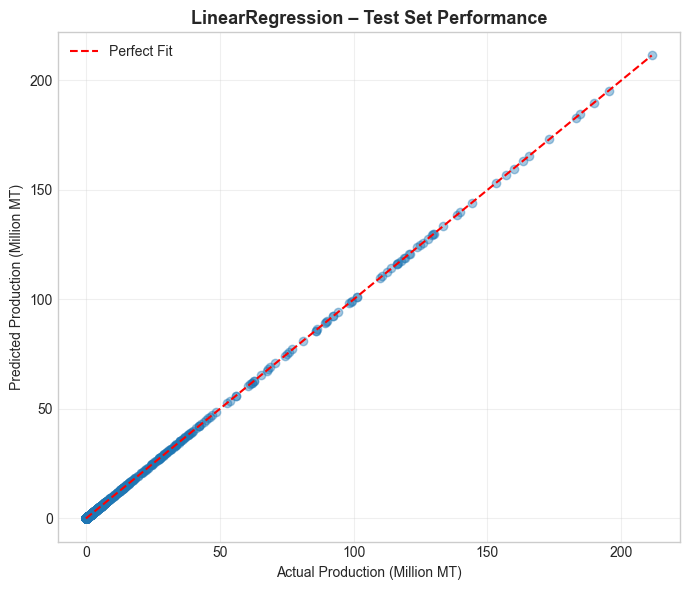

In [3]:
# -------------------------------------------------
# Step 7: Plot predictions of the best global model
# -------------------------------------------------

y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(7, 6))
plt.scatter(y_test / 1e6, y_pred_best / 1e6, alpha=0.4)
max_val = max(y_test.max(), y_pred_best.max()) / 1e6
plt.plot([0, max_val], [0, max_val], "r--", label="Perfect Fit")
plt.xlabel("Actual Production (Million MT)")
plt.ylabel("Predicted Production (Million MT)")
plt.title(f"{best_name} – Test Set Performance", fontsize=13, fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

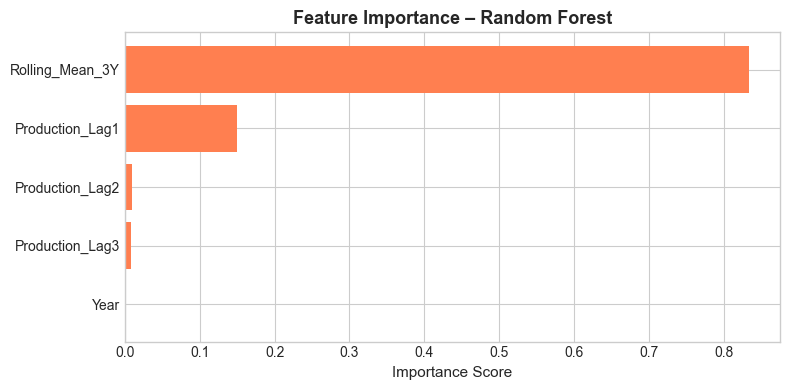


Random Forest Feature Importance:
Rolling_Mean_3Y: 0.8333
Production_Lag1: 0.1496
Production_Lag2: 0.0091
Production_Lag3: 0.0079
Year: 0.0001


In [4]:
# -----------------------------------------
# Step 8: Feature importance (for RF only)
# -----------------------------------------

# Only tree-based models have feature_importances_
if "RandomForest" in models:
    rf_model = models["RandomForest"]
    importance = pd.DataFrame(
        {
            "Feature": features,
            "Importance": rf_model.feature_importances_,
        }
    ).sort_values("Importance", ascending=False)

    plt.figure(figsize=(8, 4))
    plt.barh(importance["Feature"], importance["Importance"], color="coral")
    plt.title("Feature Importance – Random Forest", fontsize=13, fontweight="bold")
    plt.xlabel("Importance Score", fontsize=11)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nRandom Forest Feature Importance:")
    for _, row in importance.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")

In [5]:
# -------------------------------------------------
# Step 6: Train & tune multiple global models
# -------------------------------------------------

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV

features = ["Year", "Production_Lag1", "Production_Lag2", "Production_Lag3", "Rolling_Mean_3Y"]
X = df_model[features]
y = df_model["Production"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

print(f"\nTraining samples: {len(X_train):,}")
print(f"Testing samples:  {len(X_test):,}")

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 1) Random Forest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_params = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 10, 20, 30],
    "min_samples_leaf": [1, 2, 4],
}

rf_search = RandomizedSearchCV(
    rf,
    rf_params,
    n_iter=15,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)
rf_search.fit(X_train, y_train)

print("\nBest RF params:", rf_search.best_params_)
print("Best RF CV RMSE:", -rf_search.best_score_)

# 2) Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb_params = {
    "n_estimators": [200, 400],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.8, 1.0],
}

gb_search = RandomizedSearchCV(
    gb,
    gb_params,
    n_iter=15,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)
gb_search.fit(X_train, y_train)

print("\nBest GB params:", gb_search.best_params_)
print("Best GB CV RMSE:", -gb_search.best_score_)

# 3) HistGradientBoosting (fast, strong)
hgb = HistGradientBoostingRegressor(random_state=42)
hgb_params = {
    "max_depth": [None, 4, 6, 8],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_leaf_nodes": [31, 63, 127],
    "min_samples_leaf": [20, 50, 100],
}

hgb_search = RandomizedSearchCV(
    hgb,
    hgb_params,
    n_iter=15,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)
hgb_search.fit(X_train, y_train)

print("\nBest HGB params:", hgb_search.best_params_)
print("Best HGB CV RMSE:", -hgb_search.best_score_)

# Collect and compare
searches = {
    "RandomForest": rf_search,
    "GradientBoosting": gb_search,
    "HistGradientBoosting": hgb_search,
}

metrics = []
for name, search in searches.items():
    best = search.best_estimator_
    y_pred = best.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    metrics.append({"Model": name, "RMSE": rmse, "R2": r2})
    print(f"\n{name} test results:")
    print(f"  RMSE: {rmse:,.0f} MT")
    print(f"  R²:   {r2:.3f}")

metrics_df = pd.DataFrame(metrics).sort_values("R2", ascending=False)
print("\nModel comparison on test set:")
print(metrics_df)

best_name = metrics_df.iloc[0]["Model"]
best_model = searches[best_name].best_estimator_
print(f"\nBest global model: {best_name}")


Training samples: 12,091
Testing samples:  3,023
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best RF params: {'n_estimators': 600, 'min_samples_leaf': 1, 'max_depth': 30}
Best RF CV RMSE: 481102.30682316923
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best GB params: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.1}
Best GB CV RMSE: 396917.26372666593
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best HGB params: {'min_samples_leaf': 20, 'max_leaf_nodes': 31, 'max_depth': 4, 'learning_rate': 0.1}
Best HGB CV RMSE: 1356143.108472929

RandomForest test results:
  RMSE: 465,894 MT
  R²:   0.999

GradientBoosting test results:
  RMSE: 390,488 MT
  R²:   1.000

HistGradientBoosting test results:
  RMSE: 1,795,035 MT
  R²:   0.990

Model comparison on test set:
                  Model          RMSE        R2
1      GradientBoosting  3.904880e+05  0.999521
0          RandomForest  4.658945e+05  0.999318
2  HistGra

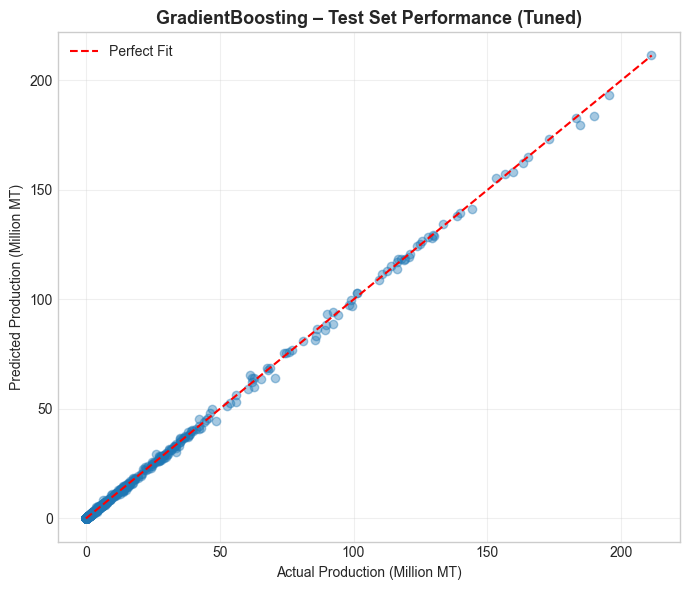

In [6]:
# -------------------------------------------------
# Step 7: Plot predictions of the best global model
# -------------------------------------------------

y_pred_best = best_model.predict(X_test)

plt.figure(figsize=(7, 6))
plt.scatter(y_test / 1e6, y_pred_best / 1e6, alpha=0.4)
max_val = max(y_test.max(), y_pred_best.max()) / 1e6
plt.plot([0, max_val], [0, max_val], "r--", label="Perfect Fit")
plt.xlabel("Actual Production (Million MT)")
plt.ylabel("Predicted Production (Million MT)")
plt.title(f"{best_name} – Test Set Performance (Tuned)", fontsize=13, fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# -----------------------------------------
# Step 8: Feature importance (from best tree model)
# -----------------------------------------

# Use RandomForest or HistGradientBoosting for feature_importances_
tree_model = None
tree_label = None

if best_name == "RandomForest":
    tree_model = best_model
    tree_label = "Random Forest"
elif best_name == "HistGradientBoosting":
    tree_model = best_model
    tree_label = "HistGradientBoosting"

if tree_model is not None and hasattr(tree_model, "feature_importances_"):
    importance = pd.DataFrame(
        {
            "Feature": features,
            "Importance": tree_model.feature_importances_,
        }
    ).sort_values("Importance", ascending=False)

    plt.figure(figsize=(8, 4))
    plt.barh(importance["Feature"], importance["Importance"], color="coral")
    plt.title(f"Feature Importance – {tree_label}", fontsize=13, fontweight="bold")
    plt.xlabel("Importance Score", fontsize=11)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print(f"\n{tree_label} Feature Importance:")
    for _, row in importance.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")


Forecasting for: World
Years available: 1963 to 2022

Trend model slope (change per year): 3,095,702 MT/year


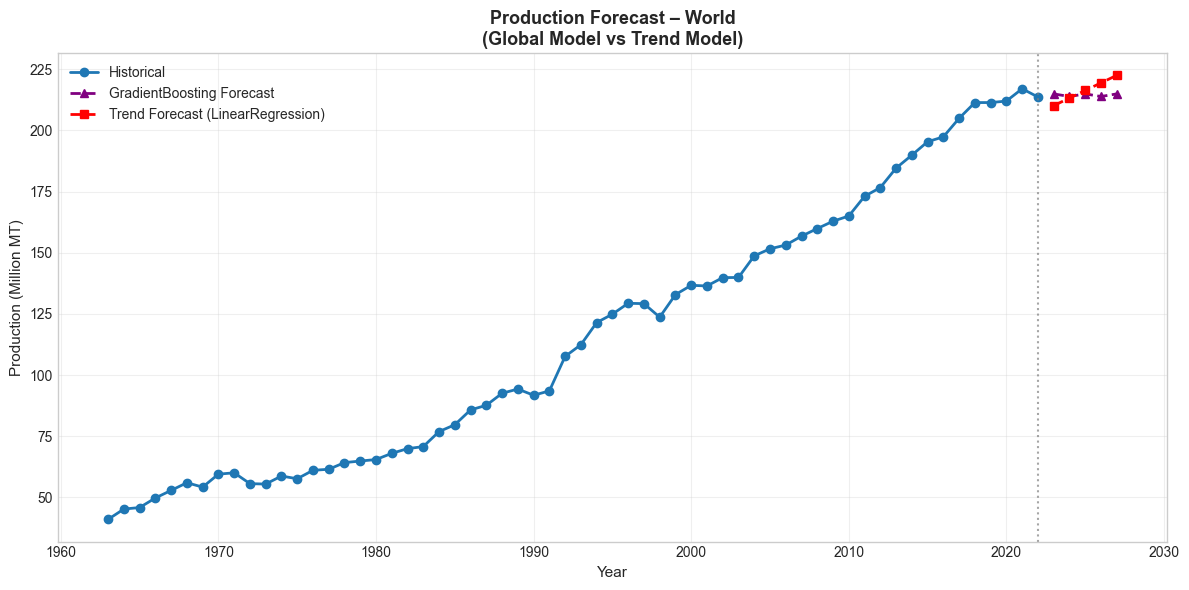


GradientBoosting forecasts for World:
  Year 2023: 214,879,723 MT
  Year 2024: 213,819,246 MT
  Year 2025: 214,879,723 MT
  Year 2026: 213,819,246 MT
  Year 2027: 214,879,723 MT

Trend-based forecasts for World:
  Year 2023: 210,082,024 MT
  Year 2024: 213,177,726 MT
  Year 2025: 216,273,428 MT
  Year 2026: 219,369,129 MT
  Year 2027: 222,464,831 MT


In [13]:
# -------------------------------------------------
# Step 9: Future forecasts – best global model + trend model
# -------------------------------------------------

from sklearn.linear_model import LinearRegression

# 1) Select country
demo_country = top10.index[0] if len(top10) > 0 else df["Country Name"].iloc[0]
if "World" in df["Country Name"].unique():
    demo_country = "World"

country_data = (
    df[df["Country Name"] == demo_country]
    .sort_values("Year")[["Year", "Production"]]
)

print(f"\nForecasting for: {demo_country}")
print("Years available:", country_data["Year"].min(), "to", country_data["Year"].max())

last_year = int(country_data["Year"].max())
future_years = np.arange(last_year + 1, last_year + 6)

# -------------------------------------------------
# 2) Forecast with best global model (iterative lags)
# -------------------------------------------------

# Need last 3 productions from full df (with lags already computed earlier)
full_country = df_model[df_model["Country Name"] == demo_country].sort_values("Year")

if len(full_country) < 3:
    raise ValueError(f"Not enough history for {demo_country} to build lag features.")

last_vals = full_country.tail(3)["Production"].tolist()

rf_future_rows = []
for year in future_years:
    feat = pd.DataFrame({
        "Year": [year],
        "Production_Lag1": [last_vals[-1]],
        "Production_Lag2": [last_vals[-2]],
        "Production_Lag3": [last_vals[-3]],
        "Rolling_Mean_3Y": [np.mean(last_vals)],
    })
    rf_pred = best_model.predict(feat)[0]
    rf_future_rows.append({"Year": year, "Production": rf_pred})
    last_vals = last_vals[1:] + [rf_pred]

rf_future_df = pd.DataFrame(rf_future_rows)

# -------------------------------------------------
# 3) Trend-based forecast with LinearRegression
# -------------------------------------------------

X_c = country_data[["Year"]]
y_c = country_data["Production"]

trend_model = LinearRegression()
trend_model.fit(X_c, y_c)

print(f"\nTrend model slope (change per year): {trend_model.coef_[0]:,.0f} MT/year")

future_X_trend = pd.DataFrame({"Year": future_years})
trend_preds = trend_model.predict(future_X_trend)

trend_df = pd.DataFrame({
    "Year": future_years,
    "Production": trend_preds,
})

# -------------------------------------------------
# 4) Plot: Historical + both forecasts
# -------------------------------------------------

plt.figure(figsize=(12, 6))

# Historical
plt.plot(
    country_data["Year"],
    country_data["Production"] / 1e6,
    marker="o",
    label="Historical",
    linewidth=2,
)

# Best global model forecast
plt.plot(
    rf_future_df["Year"],
    rf_future_df["Production"] / 1e6,
    marker="^",
    linestyle="--",
    color="purple",
    label=f"{best_name} Forecast",
    linewidth=2,
)

# Trend forecast
plt.plot(
    trend_df["Year"],
    trend_df["Production"] / 1e6,
    marker="s",
    linestyle="--",
    color="red",
    label="Trend Forecast (LinearRegression)",
    linewidth=2,
)

plt.axvline(last_year, color="gray", linestyle=":", alpha=0.7)

plt.title(f"Production Forecast – {demo_country}\n(Global Model vs Trend Model)", fontsize=13, fontweight="bold")
plt.xlabel("Year", fontsize=11)
plt.ylabel("Production (Million MT)", fontsize=11)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------------------------------------------
# 5) Print numeric forecasts
# -------------------------------------------------

print(f"\n{best_name} forecasts for {demo_country}:")
for _, row in rf_future_df.iterrows():
    print(f"  Year {int(row['Year'])}: {row['Production']:,.0f} MT")

print(f"\nTrend-based forecasts for {demo_country}:")
for _, row in trend_df.iterrows():
    print(f"  Year {int(row['Year'])}: {row['Production']:,.0f} MT")

In [9]:
print(metrics_df[metrics_df["Model"].isin(["LinearRegression", "GradientBoosting"])])

              Model           RMSE        R2
1  GradientBoosting  390487.965464  0.999521


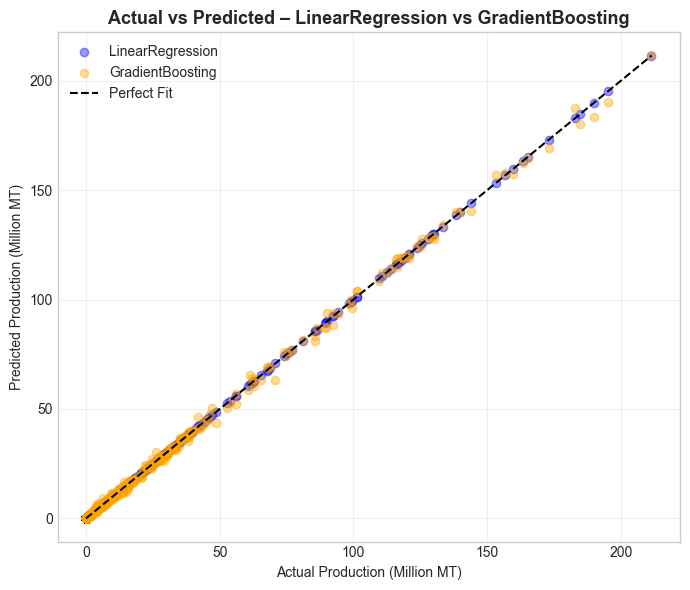

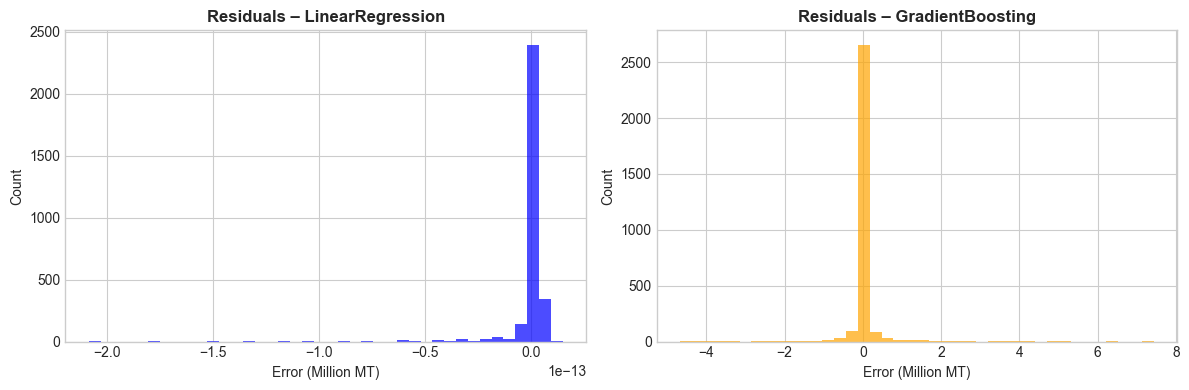

In [10]:
# -------------------------------------------------
# LinearRegression vs GradientBoosting – comparison plots
# -------------------------------------------------

lin = models["LinearRegression"]
gb  = models["GradientBoosting"]

y_pred_lin = lin.predict(X_test)
y_pred_gb  = gb.predict(X_test)

# 1) Actual vs Predicted (both models on same scatter)
plt.figure(figsize=(7, 6))
plt.scatter(y_test / 1e6, y_pred_lin / 1e6, alpha=0.4, label="LinearRegression", color="blue")
plt.scatter(y_test / 1e6, y_pred_gb / 1e6,  alpha=0.4, label="GradientBoosting", color="orange")
max_val = max(y_test.max(), y_pred_lin.max(), y_pred_gb.max()) / 1e6
plt.plot([0, max_val], [0, max_val], "k--", label="Perfect Fit")
plt.xlabel("Actual Production (Million MT)")
plt.ylabel("Predicted Production (Million MT)")
plt.title("Actual vs Predicted – LinearRegression vs GradientBoosting", fontsize=13, fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 2) Residual histograms (side by side)
res_lin = y_test - y_pred_lin
res_gb  = y_test - y_pred_gb

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(res_lin / 1e6, bins=40, color="blue", alpha=0.7)
plt.title("Residuals – LinearRegression", fontsize=12, fontweight="bold")
plt.xlabel("Error (Million MT)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(res_gb / 1e6, bins=40, color="orange", alpha=0.7)
plt.title("Residuals – GradientBoosting", fontsize=12, fontweight="bold")
plt.xlabel("Error (Million MT)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [11]:
print(
    metrics_df[metrics_df["Model"].isin(["LinearRegression", "GradientBoosting"])]
)

              Model           RMSE        R2
1  GradientBoosting  390487.965464  0.999521
